In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import requests
import os
from cobra.io import load_model
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import single_gene_deletion

#Gens essencials
from cobra.core.gene import eval_gpr
from cobra.core.gene import GPR

#MFG
from scipy.linalg import pinv

#FPE
from scipy.linalg import eig
from sklearn.preprocessing import StandardScaler


#FLOWGAT
import torch_geometric


## MODEL iML1515

In [30]:
model_path = "iYO844.json"
model = cobra.io.load_json_model(model_path)
print(f"Model: {model.id}")
print(f"Number of reactions: {len(model.reactions)}")
print(f"Number of metabolites: {len(model.metabolites)}")
print(f"Number of genes: {len(model.genes)}")

Model: iYO844
Number of reactions: 1250
Number of metabolites: 990
Number of genes: 844


In [31]:
S = cobra.util.array.create_stoichiometric_matrix(model)
S_df = pd.DataFrame(S, 
                    index=[met.id for met in model.metabolites], 
                    columns=[rxn.id for rxn in model.reactions])
S_df.to_csv('iML1515_stoichiometry.csv')
print(f"Stoichiometric matrix dimensions: {S.shape}")
print(f"Number of metabolites: {S.shape[0]}")
print(f"Number of reactions: {S.shape[1]}")

Stoichiometric matrix dimensions: (990, 1250)
Number of metabolites: 990
Number of reactions: 1250


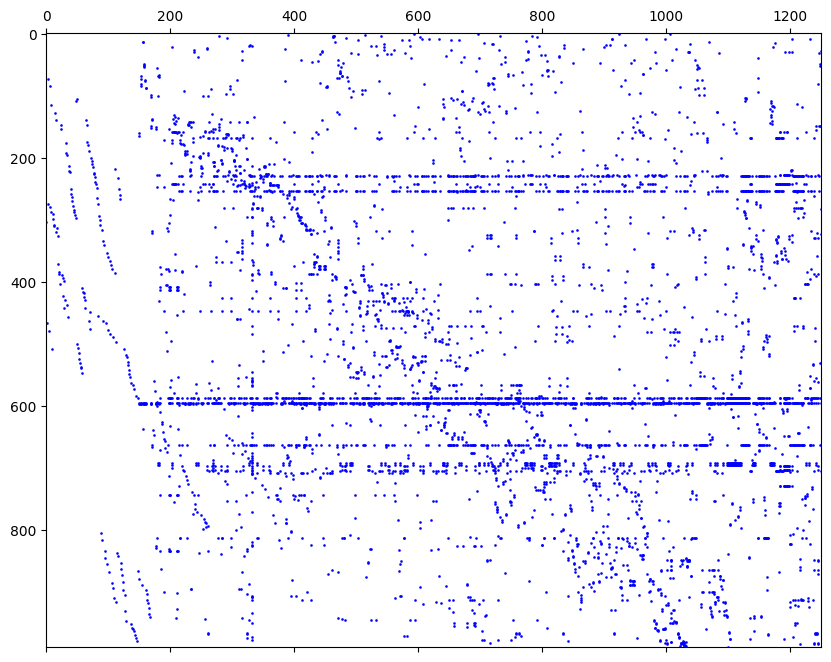

In [32]:
S_sparse = sp.csr_matrix(S_df.values)
plt.figure(figsize=(10, 8))
plt.spy(S, markersize=0.8, color='blue')

**La matriu estoiquiomètrica és molt 'sparse'. La majoria d'entrades són zero i alguns metabòlits intervenen en moltes reaccions mentre que altres només ho fan en un nombre reduit.**

## Gens essencials (ground truth)


In [5]:
essentials = pd.read_csv("essentials_ecoli.csv")
essentials_df = pd.DataFrame({"ids": [set(essentials["Gene"])]})
essentials_df

,ids
0,"{b0074, b1277, b2425, b3177, b3607, b3199, b02..."


In [33]:
data = pd.read_csv("Bacillus subtilis subsp. subtilis str. 168_genes.csv")
bacillus_ground_truth = data[['locus', 'essentiality']].copy()
essentials = bacillus_ground_truth[bacillus_ground_truth['essentiality'] =='E']
essentials_df = pd.DataFrame({"ids": [set(essentials["locus"])]})
essentials_df

,ids
0,"{BSU23170, BSU01280, BSU01350, BSU16630, BSU35..."


### Flux Balance Analysis 

In [38]:
# Creixement aeròbic en glucosa
model.reactions.EX_glc__D_e.bounds = (-10, 0) 
model.reactions.EX_o2_e.bounds = (-20, 0)

# Definim funció objectiu per a l'optimització
#model.objective = 'BIOMASS_Ec_iML1515_core_75p37M'  

# FBA
solution = model.optimize()

#Vegem les solucions
print(f"Growth rate: {solution.objective_value}")

Growth rate: 0.6241848146321055


**Ja tenim la taxa de creixement en condicions de NO eliminació de gens: 0.82179**. 
**La següent passa és eliminar les reaccions amb flux nul en nou nou dataet**: low_flux_reactions 

In [39]:
solution = model.optimize()

In [40]:
v = solution.fluxes
num_near_zero = np.sum(np.abs(v) > 1e-10)
num_near_zero

np.int64(335)

In [41]:
bounds_df = pd.DataFrame({
    'reaction': [r.id for r in model.reactions],
    'lower_bound': [r.lower_bound for r in model.reactions],
    'upper_bound': [r.upper_bound for r in model.reactions],
    'is_reversible': [reaction.lower_bound < 0 and reaction.upper_bound > 0 for reaction in model.reactions],
    'name': [r.name for r in model.reactions],    
    'flux': v
})
#bounds_df = bounds_df.merge(reaction_essentials_df, on="reaction", how="left")
bounds_df.to_csv('bounds.csv')
#Eliminarem les reaccions amb un flux molt proper a 0, ja que el resultat són nodes desconnectats a la xarxa
low_flux_reactions_df =  bounds_df[bounds_df["flux"].abs() > 1e-10]
low_flux_reactions = bounds_df[bounds_df["flux"].abs()> 1e-10]["reaction"].tolist()
reaction_indices = [i for i, r in enumerate(bounds_df["reaction"]) if r in low_flux_reactions]
S_reduced = S[:, reaction_indices]
S_reduced_df = pd.DataFrame(S_reduced, columns=low_flux_reactions)
low_flux_reactions_df
low_flux = low_flux_reactions_df[['flux']]
low_flux_reactions_df

,reaction,lower_bound,upper_bound,is_reversible,name,flux
EX_ac_e,EX_ac_e,0.0,999999.0,False,Acetate exchange,0.266596
EX_fe3_e,EX_fe3_e,-999999.0,999999.0,True,Fe3+ exchange,-0.002153
EX_glc__D_e,EX_glc__D_e,-10.0,0.0,False,D-Glucose exchange,-8.184395
EX_btd_RR_e,EX_btd_RR_e,0.0,999999.0,False,R R 2 3 Butanediol exchange,0.871565
EX_ca2_e,EX_ca2_e,-999999.0,999999.0,True,Calcium exchange,-0.002001
...,...,...,...,...,...,...
RNDR3,RNDR3,0.0,999999.0,False,Ribonucleoside-diphosphate reductase (CDP),0.010848
TECA3S45,TECA3S45,0.0,999999.0,False,Glycerol teichoic acid n45 unlinked glucos...,0.001135
PGK,PGK,-999999.0,999999.0,True,Phosphoglycerate kinase,-14.547661
PGM,PGM,-999999.0,999999.0,True,Phosphoglycerate mutase,-13.939719


### Gene-To-Protein Reaction (GPR)
Passa important per a construir el model de GNN. Les reaccions que no depenen de cap gen se'ls assignarà un -1. 

In [51]:
def assign_reaction_essentiality(model, essential_genes_df, low_flux_reactions=None):
    essential_genes_set = set()
    for gene_set in essential_genes_df['ids']:
        for gene_id in gene_set:
            essential_genes_set.add(gene_id)
    if low_flux_reactions is None:
        low_flux_reactions = [r.id for r in model.reactions]
    
    rxn_essentiality = {}
    essential_rxn_count = 0
    non_essential_rxn_count = 0
    
    for rxn_id in low_flux_reactions:
        
        rxn = model.reactions.get_by_id(rxn_id)
        #El model ja duu implementat el mapping GPR
        if not rxn.genes:
            rxn_essentiality[rxn.id] =-1
           
            continue
        
        if len(rxn.genes) == 1:
            gene = list(rxn.genes)[0]
            if gene.id in essential_genes_set:
                rxn_essentiality[rxn.id] = 1
                essential_rxn_count += 1     
            else:
                rxn_essentiality[rxn.id] = 0
                non_essential_rxn_count += 1
            
        else:
            '''
            # If multiple genes, check if at least one is essential
            essential_gene_found = any(gene.id in essential_genes_set for gene in rxn.genes)

            if essential_gene_found:
                rxn_essentiality[rxn.id] = 1  
                essential_rxn_count += 1
            else: 
                rxn_essentiality[rxn.id] = 0  # None of the genes are essential → Non-essential
                non_essential_rxn_count += 1
            
            rxn_essentiality[rxn.id] =-1  
             '''              
    print(f"Hem trobat {essential_rxn_count} reaccions essencials, {non_essential_rxn_count} reaccions no essencials")
    print(f"{len(low_flux_reactions) - essential_rxn_count - non_essential_rxn_count} reaccions amb valor desconegut")
    
    return rxn_essentiality

low_flux_essentials = assign_reaction_essentiality(model, essentials_df, low_flux_reactions)

Hem trobat 60 reaccions essencials, 146 reaccions no essencials
129 reaccions amb valor desconegut


# Mass Flow Graph (MFG)
Anem amb la construcció del MFG. 

In [52]:
flux_array = low_flux['flux'].to_numpy()  # or df['flux'].values for older pandas versions

In [53]:
len(flux_array)

335

In [54]:
def compute_mfg_with_labels(S_df, fba_solution):
    # Extract the stoichiometric matrix and reaction labels
    reaction_labels = S_df.columns.tolist()
    metabolite_labels = S_df.index.tolist()
    S = S_df.values
    
    # Get dimensions
    n_metabolites, n_reactions = S.shape
    
    # Unfold the FBA solution into forward and reverse reactions
    v_star = np.array(fba_solution)
    v_star_2m = np.concatenate([
        0.5 * (np.abs(v_star) + v_star),
        0.5 * (np.abs(v_star) - v_star)
    ])
    
    # Create label list for unfolded reactions
    unfolded_labels = []
    for label in reaction_labels:
        unfolded_labels.append(f"{label}_forward")
        unfolded_labels.append(f"{label}_reverse")
    
    # Construct the unfolded stoichiometric matrix
    I_m = np.eye(n_reactions)
    
    r = np.ones(n_reactions)  
    #r = np.array([1 if r.lower_bound < 0 else 0 for r in model.reactions])
    r = np.array(low_flux_reactions_df['is_reversible'].astype(int)) 
    diag_r = np.diag(r)
    print(f"I_m shape: {I_m.shape}")
    print(f"Zeros shape: {np.zeros((n_reactions, n_reactions)).shape}")
    print(f"diag_r shape: {diag_r.shape}")
    block_matrix = np.block([
        [I_m, np.zeros((n_reactions, n_reactions))],
        [np.zeros((n_reactions, n_reactions)), diag_r]
    ])
    
    S_2m = np.dot(np.hstack([S, -S]), block_matrix)
    
    # Calculate production and consumption matrices
    S_plus_2m = 0.5 * (np.abs(S_2m) + S_2m)
    S_minus_2m = 0.5 * (np.abs(S_2m) - S_2m)
    
    # Calculate the diagonal matrix of fluxes
    V_star = np.diag(v_star_2m)
    
    # Calculate the flux of each metabolite
    j_v_star = np.dot(S_plus_2m, v_star_2m)
    
    # Create a diagonal matrix for the inverse of j_v_star
    j_v_star_safe = np.where(j_v_star != 0, j_v_star, 1.0)  # Replace zeros with 1
    J_v_star = np.diag(1.0 / j_v_star_safe)
    
    # Calculate the MFG adjacency matrix
    S_plus_2m_V = np.dot(S_plus_2m, V_star)
    S_minus_2m_V = np.dot(S_minus_2m, V_star)
    
    M_v_star = np.dot(np.dot(S_plus_2m_V.T, J_v_star), S_minus_2m_V)
    
    # Create a DataFrame to maintain the labels
    mfg_df = pd.DataFrame(M_v_star, index=unfolded_labels, columns=unfolded_labels)
    
    # Identify the connected component
    # A node is connected if it has at least one non-zero entry in its row or column
    connected_mask = ((np.abs(M_v_star).sum(axis=0) > 1e-10) | (np.abs(M_v_star).sum(axis=1) > 1e-10))
    connected_indices = np.where(connected_mask)[0]
    
    # Check if there are any connected nodes
    if len(connected_indices) == 0:
        return {
            'full_mfg': mfg_df,
            'connected_mfg': pd.DataFrame(),
            'connected_labels': [],
            'original_connected_labels': []
        }
    
    # Extract the connected component subgraph with labels
    connected_labels = [unfolded_labels[i] for i in connected_indices]
    M_k = M_v_star[connected_indices, :][:, connected_indices]
    mfg_connected_df = pd.DataFrame(M_k, index=connected_labels, columns=connected_labels)
    
    # Map the connected reactions back to original reaction labels
    # Remove the "_forward" and "_reverse" suffixes
    original_connected_labels = []
    for label in connected_labels:
        if label.endswith("_forward"):
            original_connected_labels.append(label[:-8])
        elif label.endswith("_reverse"):
            original_connected_labels.append(label[:-8])
    
    # Remove duplicates to get unique reactions in the connected component
    original_connected_labels = list(set(original_connected_labels))
    
    return {
        'full_mfg': mfg_df,
        'connected_mfg': mfg_connected_df,
        'connected_labels': connected_labels,
        'original_connected_labels': original_connected_labels
    }

def extract_features(mfg_connected_df):
    M_k = mfg_connected_df.values
    M_k_transpose = M_k.T
    
    # Create feature matrix X = [M_k M_k']
    X = np.hstack([M_k, M_k_transpose])
    
    # Normalize features to unit variance (without centering)
    std = np.std(X, axis=0, keepdims=True)
    std[std == 0] = 1.0  # Avoid division by zero
    X_normalized = X / std
    
    # Create DataFrame with labels
    X_df = pd.DataFrame(
        X_normalized, 
        index=mfg_connected_df.index,
        columns=[f"outflow_{col}" for col in mfg_connected_df.columns] + 
                [f"inflow_{col}" for col in mfg_connected_df.columns]
    )
    
    return X_df

mfg_result = compute_mfg_with_labels(S_reduced_df, flux_array)
#mfg_result = compute_mfg_with_labels(S_df, v)
# The connected component of the MFG with labels
connected_mfg = mfg_result['connected_mfg']
X_features = extract_features(connected_mfg)
X_features


I_m shape: (335, 335)
Zeros shape: (335, 335)
diag_r shape: (335, 335)


,outflow_EX_ac_e_forward,outflow_EX_fe3_e_reverse,outflow_EX_btd_RR_e_forward,outflow_EX_btd_RR_e_reverse,outflow_EX_ca2_e_forward,outflow_EX_ca2_e_reverse,outflow_EX_so4_e_forward,outflow_EX_so4_e_reverse,outflow_EX_co2_e_reverse,outflow_EX_glyclt_e_forward,...,inflow_KAS4_reverse,inflow_KAS6_forward,inflow_KAS6_reverse,inflow_KAS11_forward,inflow_KAS11_reverse,inflow_PGMT_forward,inflow_RNDR3_forward,inflow_TECA3S45_reverse,inflow_PGM_reverse,inflow_PHCYT_BS_forward
EX_ac_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
EX_fe3_e_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
EX_btd_RR_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
EX_btd_RR_e_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
EX_ca2_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PGMT_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
RNDR3_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
TECA3S45_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
PGM_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [55]:
def map_essentiality_to_connected_mfg(mfg_result, essentiality_dict):
    connected_labels = mfg_result['connected_labels']
    essentiality_mapped = {}
    base_reaction_essentiality = {}
    for label in connected_labels:
        if label.endswith("_forward"):
            original_label = label[:-8]  
            if original_label in essentiality_dict:
                base_reaction_essentiality[original_label] = essentiality_dict[original_label]
    for label in connected_labels:
        if label.endswith("_forward"):
            original_label = label[:-8]
            essentiality_mapped[label] = base_reaction_essentiality.get(original_label, -1)
        elif label.endswith("_reverse"):
            original_label = label[:-8]
            essentiality_mapped[label] = base_reaction_essentiality.get(original_label, -1)
    
    return essentiality_mapped

def extract_features_with_labels(mfg_connected_df, essentiality_mapped):
    M_k = mfg_connected_df.values
    M_k_transpose = M_k.T
    
    # Create feature matrix X = [M_k M_k']
    X = np.hstack([M_k, M_k_transpose])
    
    # Normalize features to unit variance (without centering)
    std = np.std(X, axis=0, keepdims=True)
    std[std == 0] = 1.0  # Avoid division by zero
    X_normalized = X / std
    
    # Create DataFrame with features
    X_df = pd.DataFrame(
        X_normalized, 
        index=mfg_connected_df.index,
        columns=[f"outflow_{col}" for col in mfg_connected_df.columns] + 
                [f"inflow_{col}" for col in mfg_connected_df.columns]
    )
    
    # Add essentiality labels
    X_df['essentiality'] = X_df.index.map(lambda x: essentiality_mapped.get(x, -1))
    
    return X_df

essentiality_mapped = map_essentiality_to_connected_mfg(mfg_result, low_flux_essentials)
#essentiality_mapped = map_essentiality_to_connected_mfg(mfg_result, reaction_essentials_df)

# Conjunt de dades final:
X_with_labels = extract_features_with_labels(mfg_result['connected_mfg'], essentiality_mapped)

In [61]:
#X_with_labels[X_with_labels['essentiality'] == -1]
X_with_labels

,outflow_EX_ac_e_forward,outflow_EX_fe3_e_reverse,outflow_EX_btd_RR_e_forward,outflow_EX_btd_RR_e_reverse,outflow_EX_ca2_e_forward,outflow_EX_ca2_e_reverse,outflow_EX_so4_e_forward,outflow_EX_so4_e_reverse,outflow_EX_co2_e_reverse,outflow_EX_glyclt_e_forward,...,inflow_KAS6_forward,inflow_KAS6_reverse,inflow_KAS11_forward,inflow_KAS11_reverse,inflow_PGMT_forward,inflow_RNDR3_forward,inflow_TECA3S45_reverse,inflow_PGM_reverse,inflow_PHCYT_BS_forward,essentiality
EX_ac_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
EX_fe3_e_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
EX_btd_RR_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
EX_btd_RR_e_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
EX_ca2_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PGMT_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
RNDR3_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
TECA3S45_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
PGM_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1


In [29]:
X_esch = X_with_labels

In [63]:
def stack_graphs_diagonally(A, B, label_col_name='label'):
    """
    Stack two graph adjacency matrices diagonally to create a 2-component graph.
    
    Parameters:
    A, B: pandas DataFrames with adjacency info + labels in last column
    label_col_name: name of the label column (default: 'label')
    
    Returns:
    Combined DataFrame with block diagonal structure + labels
    """
    
    # Separate features and labels
    A_features = A.iloc[:, :-1]  # All columns except last
    A_labels = A.iloc[:, -1]     # Last column (labels)
    
    B_features = B.iloc[:, :-1]  # All columns except last  
    B_labels = B.iloc[:, -1]     # Last column (labels)
    
    # Get dimensions
    n_A = A_features.shape[0]
    n_B = B_features.shape[0]
    
    # Create block diagonal matrix
    # Top-left: A's adjacency matrix
    # Bottom-right: B's adjacency matrix  
    # Top-right and bottom-left: zeros (no connections between graphs)
    
    combined_features = np.block([
        [A_features.values, np.zeros((n_A, B_features.shape[1]))],
        [np.zeros((n_B, A_features.shape[1])), B_features.values]
    ])
    
    # Combine labels
    combined_labels = pd.concat([A_labels, B_labels], ignore_index=True)
    
    # Create column names for the combined matrix
    A_cols = [f"A_{col}" for col in A_features.columns]
    B_cols = [f"B_{col}" for col in B_features.columns]
    feature_columns = A_cols + B_cols
    
    # Create final DataFrame
    result = pd.DataFrame(combined_features, columns=feature_columns)
    result[label_col_name] = combined_labels
    
    return result

# Example usage:
# Assuming your matrices are called df_A and df_B
combined_graph = stack_graphs_diagonally(X_esch, X_with_labels, 'essentiality')

In [68]:
combined_graph[combined_graph['essentiality']==-1]

,A_outflow_SHK3Dr_forward,A_outflow_DHORTS_forward,A_outflow_DHORTS_reverse,A_outflow_OMPDC_forward,A_outflow_OMPDC_reverse,A_outflow_G5SD_forward,A_outflow_G5SD_reverse,A_outflow_CS_reverse,A_outflow_ICDHyr_forward,A_outflow_ICDHyr_reverse,...,B_inflow_KAS6_forward,B_inflow_KAS6_reverse,B_inflow_KAS11_forward,B_inflow_KAS11_reverse,B_inflow_PGMT_forward,B_inflow_RNDR3_forward,B_inflow_TECA3S45_reverse,B_inflow_PGM_reverse,B_inflow_PHCYT_BS_forward,essentiality
0,0.000000,0.00000,0.000000,0.0,0.475359,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
7,0.000036,0.00004,0.000036,0.0,0.000000,0.0,0.000036,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
10,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,16.703671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
11,0.000009,0.00001,0.000009,0.0,0.000000,0.0,0.000009,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
14,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
758,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
760,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
761,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


És important entendre que això no és ben bé una matriu d'adjacència. Cal mirar-ho com cadascun dels 'embeddings' dels nodes, un vector que no només indica allò que 'surt' de cada node, sinó allò que 'entra'. Precisament per això el tamany de l'array és nx(n+1), on la darrera columna són les etiquetes de cada node. 

## GNN (GAT)

Training fold 1/5
Epoch: 20, Train Loss: 0.4460, Val Loss: 0.4207, Val Acc: 0.7959
Epoch: 40, Train Loss: 0.3120, Val Loss: 0.6097, Val Acc: 0.7551
Epoch: 60, Train Loss: 0.2957, Val Loss: 0.9179, Val Acc: 0.7755
Epoch: 80, Train Loss: 0.2439, Val Loss: 0.8396, Val Acc: 0.7347
Epoch: 100, Train Loss: 0.2194, Val Loss: 0.8253, Val Acc: 0.8367
Epoch: 120, Train Loss: 0.2005, Val Loss: 1.3411, Val Acc: 0.7551
Epoch: 140, Train Loss: 0.1661, Val Loss: 1.2346, Val Acc: 0.7551
Epoch: 160, Train Loss: 0.1441, Val Loss: 1.5204, Val Acc: 0.6939
Epoch: 180, Train Loss: 0.1422, Val Loss: 1.5289, Val Acc: 0.7143
Epoch: 200, Train Loss: 0.1526, Val Loss: 1.4695, Val Acc: 0.7347
Epoch: 220, Train Loss: 0.1685, Val Loss: 2.0708, Val Acc: 0.6939
Epoch: 240, Train Loss: 0.1543, Val Loss: 2.4952, Val Acc: 0.5714
Epoch: 260, Train Loss: 0.1416, Val Loss: 1.8717, Val Acc: 0.6122
Training fold 2/5
Epoch: 20, Train Loss: 0.4604, Val Loss: 0.7785, Val Acc: 0.7347
Epoch: 40, Train Loss: 0.3602, Val Loss: 0.98

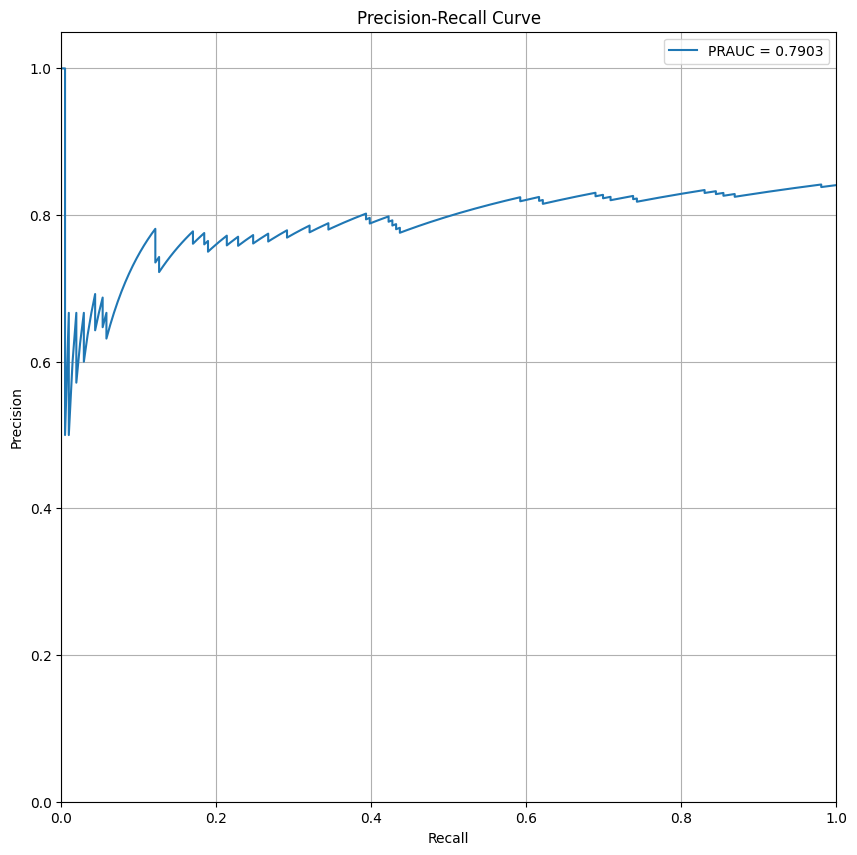

Average PR-AUC: 0.7903
Average F1 Score (threshold=0.5717): 0.8321
Precision: 0.8341
Recall: 0.8301


In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
from tqdm import tqdm
import itertools

class FlowGAT(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads=8, dropout=0.6):
        super(FlowGAT, self).__init__()
        
        # Capa n.1
        self.gat1 = GATConv(
            in_features, 
            hidden_features, 
            heads=num_heads, 
            dropout=dropout,
            concat=True  # Output no simple (concatenació)
        )
        
        # Capa n.2
        self.gat2 = GATConv(
            hidden_features * num_heads,
            out_features,
            heads=1,
            dropout=dropout,
            concat=False  # Output únic (predicció final) 
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        # Primera capa amb activació ReLU
        x = self.gat1(x, edge_index, edge_weight)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index, edge_weight)       
        return x
'''
def prepare_graph_data(adjacency_matrix, fpe_features, reaction_essentiality): 
    # Use NumPy to get nonzero indices and values (efficient)
    rows, cols = np.nonzero(adjacency_matrix)  
    edge_index = torch.tensor(np.vstack((rows, cols)), dtype=torch.long)
    edge_weight = torch.tensor(adjacency_matrix[rows, cols], dtype=torch.float)

    # Convert FPE features to tensor
    x = torch.tensor(fpe_features, dtype=torch.float)

    # Create graph data object
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

    # Extract labeled nodes (excluding -1)
    labeled_indices = []
    labels = []
    
    for idx, (rxn_id, label) in enumerate(reaction_essentiality.items()):
        if label != -1:  # Only include valid labels
            labeled_indices.append(idx)
            labels.append(label)

    # Convert lists to tensors
    labeled_indices = torch.tensor(labeled_indices, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    return data, labeled_indices, labels
'''

def prepare_graph_data_from_mfg(X_with_labels):
    features = X_with_labels.drop('essentiality', axis=1).values
    labels_series = X_with_labels['essentiality']
    
    all_indices = np.arange(len(labels_series))
    labeled_mask = labels_series != -1
    labeled_indices = all_indices[labeled_mask]
    labels = labels_series[labeled_mask].values
    
    
    num_nodes = features.shape[0]
    adjacency_matrix = features[:, :num_nodes]  # 1a meitat de la matriu (sense la segona part transposta)

    #Recollim informació del flux
    rows, cols = np.nonzero(adjacency_matrix)  
    edge_index = torch.tensor(np.vstack((rows, cols)), dtype=torch.long)
    edge_weight = torch.tensor(adjacency_matrix[rows, cols], dtype=torch.float)
    
    x = torch.tensor(features, dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
    
    labeled_indices = torch.tensor(labeled_indices, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return data, labeled_indices, labels

def train_flowgat(data, labeled_indices, labels, hyperparams, n_splits=5, epochs=260):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)
    
    # Hiperparàmetres
    hidden_features = hyperparams['hidden_features']
    num_heads = hyperparams['num_heads']
    dropout = hyperparams['dropout']
    lr = hyperparams['lr']
    weight_decay = hyperparams['weight_decay']
    
    if hyperparams.get('use_class_weights', False):
        if isinstance(labels, torch.Tensor):
            num_pos = torch.sum(labels == 1).item()
            num_neg = torch.sum(labels == 0).item()
        else:
            num_pos = np.sum(labels == 1)
            num_neg = np.sum(labels == 0)
        pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float).to(device)
    else:
        pos_weight = None
    

    labeled_indices_np = labeled_indices.cpu().numpy() if isinstance(labeled_indices, torch.Tensor) else np.array(labeled_indices)
    labels_np = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else np.array(labels)
    
    # k-fold estratificat (per la falta d'equilibri en les classes)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    models = []
    val_indices_list = []
    predictions_list = []
    true_labels_list = []
    

    train_stats = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    
    # cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(labeled_indices_np, labels_np)):
        print(f"Training fold {fold+1}/{n_splits}")
        
        
        train_mask = labeled_indices_np[train_idx]
        val_mask = labeled_indices_np[val_idx]
        
        
        in_features = data.x.shape[1]
        model = FlowGAT(
            in_features=in_features, 
            hidden_features=hidden_features, 
            out_features=1,
            num_heads=num_heads,
            dropout=dropout
        ).to(device)
        
        # Optimitzador ADAM
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        y = torch.tensor(labels_np, dtype=torch.float).to(device)
        
        # Training loop
        fold_train_loss = []
        fold_val_loss = []
        fold_val_accuracy = []
        fold_val_precision = []
        fold_val_recall = []
        fold_val_f1 = []
        
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight)
            
            # Binary cross entropy 
            if pos_weight is not None:
                loss = F.binary_cross_entropy_with_logits(
                    out[train_mask].view(-1), 
                    y[train_idx], 
                    pos_weight=pos_weight
                )
            else:
                loss = F.binary_cross_entropy_with_logits(
                    out[train_mask].view(-1), 
                    y[train_idx]
                )
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Print training progress
            if (epoch + 1) % 20 == 0:
                model.eval()
                with torch.no_grad():
                    val_out = out[val_mask].view(-1)
                    val_loss = F.binary_cross_entropy_with_logits(val_out, y[val_idx])
                    
                    # FUNCIÓ SIGMOIDE
                    val_probs = torch.sigmoid(val_out)
                    pred_binary = (val_probs > 0.5).float()
                    
                    # mètriques
                    val_labels_np = y[val_idx].cpu().numpy()
                    pred_binary_np = pred_binary.cpu().numpy()
                    
                    accuracy = accuracy_score(val_labels_np, pred_binary_np)
                    
                    try:
                        prec = precision_score(val_labels_np, pred_binary_np)
                    except:
                        prec = 0.0
                    
                    try:
                        rec = recall_score(val_labels_np, pred_binary_np)
                    except:
                        rec = 0.0
                    
                    try:
                        f1 = f1_score(val_labels_np, pred_binary_np)
                    except:
                        f1 = 0.0
                    
                    print(f"Epoch: {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {accuracy:.4f}")
                    

                    fold_train_loss.append(loss.item())
                    fold_val_loss.append(val_loss.item())
                    fold_val_accuracy.append(accuracy)
                    fold_val_precision.append(prec)
                    fold_val_recall.append(rec)
                    fold_val_f1.append(f1)
        
        # Store fold statistics
        train_stats['train_loss'].append(fold_train_loss)
        train_stats['val_loss'].append(fold_val_loss)
        train_stats['val_accuracy'].append(fold_val_accuracy)
        train_stats['val_precision'].append(fold_val_precision)
        train_stats['val_recall'].append(fold_val_recall)
        train_stats['val_f1'].append(fold_val_f1)
        
        # Avaluació final
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.edge_weight)
            val_pred = torch.sigmoid(out[val_mask].view(-1)).cpu().numpy()
        
        models.append(model)
        val_indices_list.append(val_idx)
        predictions_list.append(val_pred)
        true_labels_list.append(y[val_idx].cpu().numpy())
    
    return models, val_indices_list, predictions_list, true_labels_list, train_stats

def evaluate_results(val_indices_list, predictions_list, true_labels_list):
   
   
    all_preds = np.concatenate(predictions_list)
    all_labels = np.concatenate(true_labels_list)
    
    # PRAUC
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
    pr_auc = auc(recall, precision)
    
    # F1 score BALANCEJAT
    f1_scores = []
    for t in thresholds:
        try:
            f1 = f1_score(all_labels, (all_preds >= t).astype(int), average="macro")
            f1_scores.append(f1)
        except:
            f1_scores.append(0.0)
    
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    
    binary_preds = (all_preds >= best_threshold).astype(int)
    f1 = f1_score(all_labels, binary_preds)
    prec = precision_score(all_labels, binary_preds)
    rec = recall_score(all_labels, binary_preds)

    # Plot precision-recall curve
    plt.figure(figsize=(10, 10))
    plt.plot(recall, precision, label=f'PRAUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.ylim([0.0, 1.05])  # Set y-axis limits to show full [0,1] range with small margin
    plt.xlim([0.0, 1.0])   # Set x-axis limits for consistency
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Average PR-AUC: {pr_auc:.4f}")
    print(f"Average F1 Score (threshold={best_threshold:.4f}): {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    
    return pr_auc, f1, prec, rec

def grid_search_flowgat(data, labeled_indices, labels, n_splits=5, cv_epochs=140):
    param_grid = {
        'hidden_features': [8, 16, 32],
        'num_heads': [4, 8],
        'dropout': [0.3, 0.5],
        'lr': [0.01, 0.005, 0.001,0.0005],
        'weight_decay': [5e-4, 1e-4],
        'use_class_weights': [True, False]
    }
    
    for key in param_grid:
        if not isinstance(param_grid[key], list):
            param_grid[key] = [param_grid[key]]
    
    # Choose a subset of hyperparameter combinations to test
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(itertools.product(*values))
    
    # Sample combinations if there are too many
    max_combinations = 12  # Adjust based on your computational resources
    if len(combinations) > max_combinations:
        np.random.seed(42)
        indices = np.random.choice(len(combinations), max_combinations, replace=False)
        combinations = [combinations[i] for i in indices]
    
    # Initialize results tracking
    results = []
    best_prauc = 0.0
    best_params = None
    
    # Iterate through parameter combinations
    for i, params in enumerate(combinations):
        hyperparams = {keys[j]: params[j] for j in range(len(keys))}
        print(f"\nHyperparameter combination {i+1}/{len(combinations)}:")
        print(hyperparams)
        
        # Train and evaluate model with current hyperparameters
        models, val_indices_list, predictions_list, true_labels_list, _ = train_flowgat(
            data, 
            labeled_indices, 
            labels, 
            hyperparams, 
            n_splits=n_splits, 
            epochs=cv_epochs
        )
        
        # Evaluate model
        pr_auc, f1, precision, recall = evaluate_results(val_indices_list, predictions_list, true_labels_list)
        
        # Store results
        result = {
            **hyperparams,
            'prauc': pr_auc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }
        results.append(result)
        
        # Update best parameters
        if pr_auc > best_prauc:
            best_prauc = pr_auc
            best_params = hyperparams
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by PR-AUC
    results_df = results_df.sort_values('prauc', ascending=False).reset_index(drop=True)
    
    print("\nGrid Search Results:")
    print(results_df.head())
    
    print("\nBest Hyperparameters:")
    print(best_params)
    print(f"Best PR-AUC: {best_prauc:.4f}")
    
    # Save results to CSV
    results_df.to_csv('grid_search_results.csv', index=False)
    
    return best_params, best_prauc, results_df

def train_and_evaluate_final_model(data, labeled_indices, labels, best_params, n_splits=5, epochs=260):
    # Train final model with best hyperparameters
    models, val_indices_list, predictions_list, true_labels_list, train_stats = train_flowgat(
        data, 
        labeled_indices, 
        labels, 
        best_params, 
        n_splits=n_splits, 
        epochs=epochs
    )
    
    # Evaluate final model
    pr_auc, f1, precision, recall = evaluate_results(val_indices_list, predictions_list, true_labels_list)
    
    # Compile metrics
    metrics = {
        'prauc': pr_auc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    
    # Plot training curves
    #plot_training_curves(train_stats)
    
    return models, metrics, train_stats

def predict_with_flowgat(models, data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)
    
    # Make predictions with each model
    all_preds = []
    for model in models:
        model.eval()
        with torch.no_grad():
            # Get raw logits and apply sigmoid
            logits = model(data.x, data.edge_index, data.edge_weight).view(-1)
            pred_probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.append(pred_probs)
    
    # Average predictions
    ensemble_preds = np.mean(all_preds, axis=0)
    binary_preds = (ensemble_preds >= 0.5).astype(int)
    
    #return ensemble_preds
    

    return ensemble_preds, binary_preds

if __name__ == "__main__":
    data, labeled_indices, labels = prepare_graph_data_from_mfg(X_esch)
    #data, labeled_indices, labels = prepare_graph_data_from_mfg(bacillus)

    
    #best_params, best_prauc, results_df = grid_search_flowgat(data, labeled_indices, labels)
    
    # Example of training final model
    
    models, metrics, train_stats = train_and_evaluate_final_model(data, labeled_indices, labels, best_params)

    ensemble_predictions = predict_with_flowgat(models, data)

In [105]:
ensemble_predictions = ensemble_predictions[0]

In [122]:
prediction_df = pd.DataFrame({
    'node_index': range(len(ensemble_predictions)),
    'prediction_score': ensemble_predictions,
    'predicted_class': (ensemble_predictions >= 0.9).astype(int)
})

# Add actual labels for nodes that have them
labeled_indices_np = np.array(labeled_indices)
labels_np = np.array(labels)
for i, idx in enumerate(labeled_indices_np):
    prediction_df.loc[prediction_df['node_index'] == idx, 'true_label'] = labels_np[i]

# Calculate error type (FP, FN, TP, TN)
prediction_df['error_type'] = prediction_df.apply(
    lambda row: 'Unknown' if pd.isna(row['true_label']) else
    ('TP' if row['predicted_class'] == 1 and row['true_label'] == 1 else
     'TN' if row['predicted_class'] == 0 and row['true_label'] == 0 else
     'FP' if row['predicted_class'] == 1 and row['true_label'] == 0 else 'FN'),
    axis=1
)

C:\Users\Miki\AppData\Local\Temp\ipykernel_52888\2257147577.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labeled_indices_np = np.array(labeled_indices)
C:\Users\Miki\AppData\Local\Temp\ipykernel_52888\2257147577.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labels_np = np.array(labels)


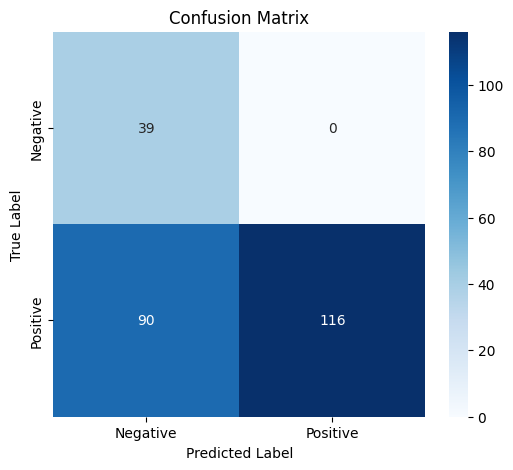

Classification Report:
               precision    recall  f1-score   support

           0       0.30      1.00      0.46        39
           1       1.00      0.56      0.72       206

    accuracy                           0.63       245
   macro avg       0.65      0.78      0.59       245
weighted avg       0.89      0.63      0.68       245



In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Remove rows where 'true_label' is NaN (they are not part of the evaluation)
filtered_df = prediction_df.dropna(subset=['true_label']).copy()

# Ensure 'true_label' and 'predicted_class' are integers
filtered_df['true_label'] = filtered_df['true_label'].astype(int)
filtered_df['predicted_class'] = filtered_df['predicted_class'].astype(int)

# Compute confusion matrix
cm = confusion_matrix(filtered_df['true_label'], filtered_df['predicted_class'])

# Define labels for the confusion matrix
labelss = ["Negative", "Positive"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labelss, yticklabels=labelss)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(filtered_df['true_label'], filtered_df['predicted_class']))


In [504]:
bacillus = pd.read_csv('Y_with_labels.csv', index_col=0)

In [59]:
best_params

{'hidden_features': 32,
 'num_heads': 8,
 'dropout': 0.5,
 'lr': 0.01,
 'weight_decay': 0.0005,
 'use_class_weights': False}

In [127]:
acc_combined = [0.62,0.78,0.84,0.89,0.9,0.89,0.88,0.83,0.69]
acc_bacillus = [0.47, 0.80,0.88,0.91,0.91,0.85,0.83,0.79,0.69]
acc_ecoli = [0.77,0.81,0.92,0.93,0.94,0.95,0.95,0.89,0.68]
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

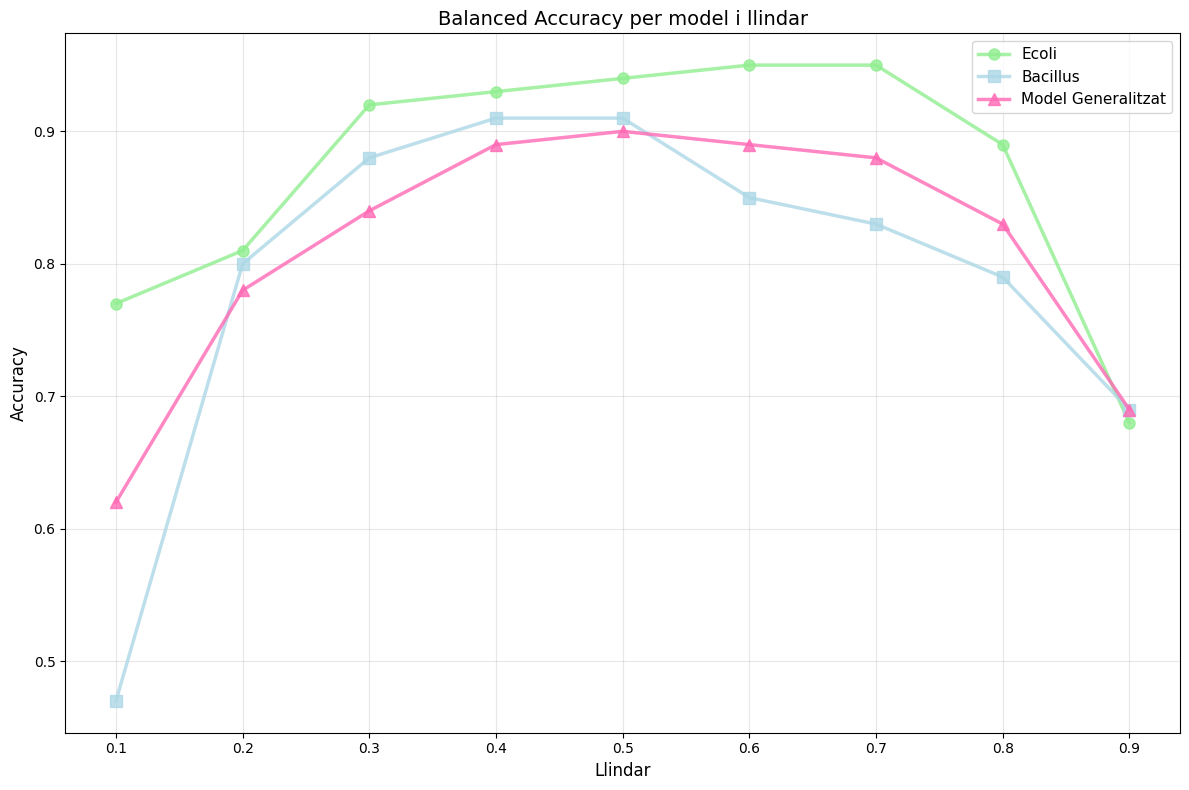

In [141]:
plt.figure(figsize=(12, 8))
colors = ['#90EE90','#ADD8E6', '#FF69B4']  # Blue, Orange, Green
markers = ['o', 's', '^']
labels = ['Ecoli', 'Bacillus', 'Model Generalitzat']

for i, (acc_vector, color, marker, label) in enumerate(zip(
    [acc_ecoli, acc_bacillus, acc_combined], colors, markers, labels)):
    plt.plot(thresholds, acc_vector, 
             color=color, marker=marker, label=label,
             linewidth=2.5, markersize=8, alpha=0.8)

plt.xlabel('Llindar', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Balanced Accuracy per model i llindar', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()